# Machine Learning on Distributed Dask with SageMaker and Fargate

This notebook will demonstrate how to perform Machine Learning on Distributed Dask using SageMaker and Fargate.  We will demo how to connect to distributed dask fargate cluster, scale out dask worker nodes, perform EDA work on public newyork cab trip data sets. Then, we demonstrate how you can run regression algorithms and hyperparameters optimization on distributed dask cluster. Next, we will demonstrate how you can monitor the operational metrics of Dask Cluster that will be fronted by Network Load Balancer for accessing the Dask Cluster Status UI from internet. Finally, we will close with how to build your own python script container and run against the dask fargate cluster.  This notebook was inspired by customer use case where they were running dask on local computer for building regression models.   

## Setup required packages

In [ ]:
!conda install -c conda-forge scikit-learn==0.23 -y

In [ ]:
!conda install -y dask=2.14

In [ ]:
!conda install -c conda-forge s3fs=0.3.0 -y

In [2]:
!conda install -c conda-forge matplotlib=3.3.1 -y

Solving environment: done

## Package Plan ##

  environment location: /Users/rvvittal/opt/anaconda3

  added / updated specs:
    - matplotlib=3.3.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-base-3.3.1      |   py37h181983e_0         5.1 MB
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following NEW packages will be INSTALLED:

  cycler             conda-forge/noarch::cycler-0.10.0-py_2
  kiwisolver         conda-forge/osx-64::kiwisolver-1.2.0-py37ha1cc60f_0
  matplotlib         conda-forge/osx-64::matplotlib-3.3.1-1
  matplotlib-base    pkgs/main/osx-64::matplotlib-base-3.3.1-py37h181983e_0

The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.4-py37_0 --> conda-forge::conda-4.8.4-py37hc8dfbb8_2
  openssl              pkgs/main::openssl-1.1.

## Connect to Dask Fargate Cluster.  You need to provision this cluster following the instructions from here https://github.com/rvvittal/aws-dask-sm-fargate

In [3]:
from dask.distributed import Client
client = Client('localhost:8786')

## Scale out the number of dask workers as needed for your data science work

In [ ]:
#!aws ecs update-service --service Dask-Workers --desired-count 20 --cluster Fargate-Dask-Cluster

## Restart the client after scale out operation

In [4]:
client.restart()

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.09 GB


## Load dask dataframe with the trip data


## TODO: Introduction to Dask DataFrame

In [5]:
import s3fs
import dask.dataframe as dd
import boto3
import dask.distributed
#df = dd.read_csv('s3://octank-claims-web/public-data/yellow_tripdata_2018-01.csv', storage_options={'anon': False})
# df = dd.read_csv('s3://nyc-tlc/trip data/green_tripdata_2018-02.csv', storage_options={'anon': True})

In [6]:
df = dd.read_csv(
    's3://nyc-tlc/trip data/green_tripdata_2018-02.csv', storage_options={'anon': True}
)

In [7]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2018-02-01 00:39:38,2018-02-01 00:39:41,N,5,97,65,1,0.00,20.0,0.0,0.0,3.00,0.0,NaN,0.0,23.00,1,2
1,2,2018-02-01 00:58:28,2018-02-01 01:05:35,N,1,256,80,5,1.60,7.5,0.5,0.5,0.88,0.0,NaN,0.3,9.68,1,1
2,2,2018-02-01 00:56:05,2018-02-01 01:18:54,N,1,25,95,1,9.60,28.5,0.5,0.5,5.96,0.0,NaN,0.3,35.76,1,1
3,2,2018-02-01 00:12:40,2018-02-01 00:15:50,N,1,61,61,1,0.73,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,2,1
4,2,2018-02-01 00:45:18,2018-02-01 00:51:56,N,1,65,17,2,1.87,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2,1


In [8]:
# load and count number of rows
len(df)

769940

In [9]:
df.dtypes

VendorID                   int64
lpep_pickup_datetime      object
lpep_dropoff_datetime     object
store_and_fwd_flag        object
RatecodeID                 int64
PULocationID               int64
DOLocationID               int64
passenger_count            int64
trip_distance            float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
ehail_fee                float64
improvement_surcharge    float64
total_amount             float64
payment_type               int64
trip_type                  int64
dtype: object

## Persist multiple Dask collections into memory

In [10]:
df_persisted = client.persist(df)
print(df_persisted.head())

   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2018-02-01 00:39:38   2018-02-01 00:39:41                  N   
1         2  2018-02-01 00:58:28   2018-02-01 01:05:35                  N   
2         2  2018-02-01 00:56:05   2018-02-01 01:18:54                  N   
3         2  2018-02-01 00:12:40   2018-02-01 00:15:50                  N   
4         2  2018-02-01 00:45:18   2018-02-01 00:51:56                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0           5            97            65                1           0.00   
1           1           256            80                5           1.60   
2           1            25            95                1           9.60   
3           1            61            61                1           0.73   
4           1            65            17                2           1.87   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  ehail_fee  \
0  

## Compute the mean trip distance grouped by the number of passengers

In [11]:
grouped_df = df.groupby(df_persisted.passenger_count).trip_distance.mean().compute()
print(grouped_df)

passenger_count
0    2.248809
1    2.719773
2    2.800221
3    2.763138
4    2.660013
5    2.740212
6    2.653089
7    1.260000
8    1.013571
9    0.132500
Name: trip_distance, dtype: float64


## Compute Max trip distance

In [12]:
max_trip_dist = df_persisted.trip_distance.max().compute()
print(max_trip_dist)

120.47


## Count the total trip distance and count for each vendor

In [13]:
%%time
df.groupby('VendorID').agg({'passenger_count':'count', 'trip_distance': 'sum'}).astype(int).reset_index()\
.rename(columns={'passenger_count':'Trip Count'}).compute()

CPU times: user 51.3 ms, sys: 7.7 ms, total: 59 ms
Wall time: 22.5 s


,VendorID,Trip Count,trip_distance
0,1,131590,339995
1,2,638350,1758388


## Count Missing Values for Each Feature

In [14]:
df.isna().sum().compute()

VendorID                      0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag            0
RatecodeID                    0
PULocationID                  0
DOLocationID                  0
passenger_count               0
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                769940
improvement_surcharge         0
total_amount                  0
payment_type                  0
trip_type                     0
dtype: int64

##  Visual EDA  
- ref https://medium.com/datadriveninvestor/analyzing-big-data-with-dask-a05a8798da8c

In [15]:
##Selecting top 10 rides based on fare amount
most_paid_rides_dask = df[['PULocationID', 'fare_amount']].nlargest(10, "fare_amount")

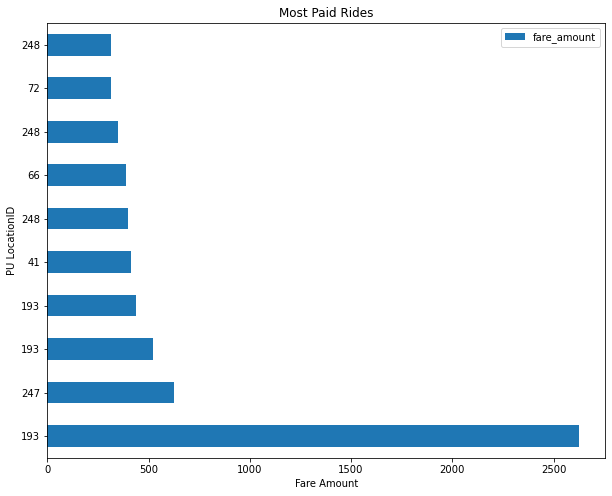

In [16]:
##Visualizing most paid rides through Barplot
import matplotlib.pyplot as plt
most_paid_rides_dask.set_index('PULocationID',sorted=True).compute().plot(kind='barh',stacked=False, figsize=[10,8], legend=True)
#######
plt.title('Most Paid Rides')
plt.xlabel('Fare Amount')
plt.ylabel('PU LocationID')
plt.show()


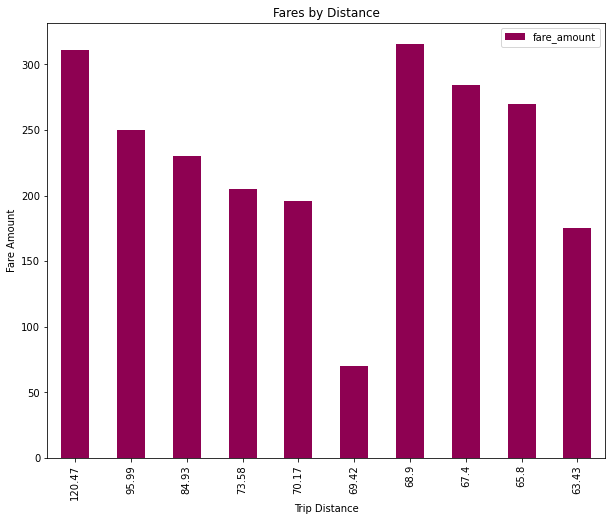

In [17]:
##Visualizing trip distance through Barplot
import matplotlib.pyplot as plt
most_paid_rides_dask2 = df[['trip_distance', 'fare_amount']].nlargest(10, "trip_distance")
most_paid_rides_dask2.set_index('trip_distance',sorted=True).compute().plot(kind='bar', colormap='PiYG', stacked=False, figsize=[10,8], legend=True)
#######
plt.title('Fares by Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

## TODO: Regression modeling with Scikit Learn

In [ ]:
import pandas as pd
taxi = pd.read_csv(
    's3://nyc-tlc/trip data/green_tripdata_2018-02.csv',
    parse_dates=['lpep_pickup_datetime', 'lpep_dropoff_datetime'],
).sample(frac=0.1, replace=False)


In [ ]:
import datetime


taxi['pickup_weekday'] = taxi.lpep_pickup_datetime.dt.weekday
taxi['pickup_weekofyear'] = taxi.lpep_pickup_datetime.dt.weekofyear
taxi['pickup_hour'] = taxi.lpep_pickup_datetime.dt.hour
taxi['pickup_minute'] = taxi.lpep_pickup_datetime.dt.minute
taxi['pickup_year_seconds'] = (taxi.lpep_pickup_datetime - datetime.datetime(2019, 1, 1, 0, 0, 0)).dt.seconds
taxi['pickup_week_hour'] = (taxi.pickup_weekday * 24) + taxi.pickup_hour
taxi['passenger_count'] = taxi.passenger_count.astype(float).fillna(-1)
taxi = taxi.fillna(value={'VendorID': 'missing', 'RatecodeID': 'missing', 'store_and_fwd_flag': 'missing' })

# keep track of column names for pipeline steps
numeric_feat = ['pickup_weekday',  'pickup_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_year_seconds', 'pickup_week_hour',  'passenger_count']
categorical_feat = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID']
features = numeric_feat + categorical_feat
y_col = 'total_amount'

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
    ('preprocess', ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_feat),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_feat),
    ])),
    ('clf', ElasticNet(normalize=False, max_iter=100)),
])

# this is our grid
params = {
    'clf__l1_ratio': np.arange(0, 1.01, 0.01),
    'clf__alpha': [0, 0.5, 1, 2],
}

grid_search = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(taxi[features], taxi[y_col])
print(grid_search.best_score_)


In [ ]:
import numpy as np
# this is our grid
params = {
    'clf__l1_ratio': np.arange(0, 1.01, 0.01),
    'clf__alpha': [0, 0.5, 1, 2],
}


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

from dask_ml.compose import ColumnTransformer
from dask_ml.preprocessing import StandardScaler, DummyEncoder, Categorizer
from dask_ml.model_selection import GridSearchCV

# Dask has slightly different way of one-hot encoding
pipeline = Pipeline(steps=[
    ('categorize', Categorizer(columns=categorical_feat)),
    ('onehot', DummyEncoder(columns=categorical_feat)),
    ('scale', ColumnTransformer(transformers=[('num', StandardScaler(), numeric_feat)])),
    ('clf', ElasticNet(normalize=False, max_iter=100)),
])

# params same as above
grid_search = GridSearchCV(pipeline, params, cv=3, scoring='neg_mean_squared_error')


In [ ]:
from joblib import _dask, parallel_backend
from sklearn.utils import register_parallel_backend
from joblib import parallel_backend
register_parallel_backend('distributed',_dask.DaskDistributedBackend)
import numpy as np
from time import time

In [ ]:
#start = time()
#with parallel_backend('distributed', scheduler_host='dask-Scheduler.local-dask:8786'):
#    grid_search.fit(taxi[features], taxi[y_col])

In [ ]:
#grid_search.fit(taxi[features], taxi[y_col])
#print(grid_search.best_score_)

In [ ]:
#print(grid_search.best_score_)

In [ ]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


In [ ]:
# Scale Up: set categories=None to use all the categories
categories = [
    'alt.atheism',
    'talk.religion.misc',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

In [ ]:
pipeline = Pipeline([
    ('vect', HashingVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=1000)),
])


In [ ]:
parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    # 'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__n_iter': (10, 50, 80),
}


In [ ]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, refit=False, iid=False)

In [ ]:
grid_search.fit(data.data, data.target)

In [ ]:
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(data.data, data.target)

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from joblib import _dask, parallel_backend
from joblib import register_parallel_backend
from joblib import parallel_backend
register_parallel_backend('distributed',_dask.DaskDistributedBackend)
import numpy as np
from time import time

In [ ]:
# Loading the Digits dataset
import joblib
digits = datasets.load_digits()
# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = RandomForestClassifier(n_estimators=20)
# use a full grid over all parameters
param_grid = {"max_depth": [3,4,5,6, None],
              "max_features": [1, 3, 10, None],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=8, iid=True)
start = time()

with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)
    clf.fit(X, y)

#with parallel_backend('distributed', scheduler_host='dask-Scheduler.local-dask:8786'):
#    grid_search.fit(X, y)
#    clf.fit(X, y)

### create pipeline for regression model

In [ ]:
from dask_ml.compose import ColumnTransformer
from dask_ml.preprocessing import StandardScaler, DummyEncoder, Categorizer
from dask_ml.model_selection import GridSearchCV

# Dask has slightly different way of one-hot encoding
pipeline = Pipeline(steps=[
    ('categorize', Categorizer(columns=categorical_feat)),
    ('onehot', DummyEncoder(columns=categorical_feat)),
    ('scale', ColumnTransformer(transformers=[('num', StandardScaler(), numeric_feat)])),
    ('clf', ElasticNet(normalize=False, max_iter=100)),
])

# params same as above
grid_search = GridSearchCV(pipeline, params, cv=3, scoring='neg_mean_squared_error')



## Distributed Machine Learning with Dask

Scikit-learn uses joblib for single-machine parallelism. This lets you train most estimators (anything that accepts an n_jobs parameter) using all the cores of your laptop or workstation.Alternatively, Scikit-Learn can use Dask for parallelism. This lets you train those estimators using all the cores of your cluster without significantly changing your code.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd


In [ ]:
X, y = make_classification(n_samples=1000, random_state=0)
X[:5]

In [ ]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           iid=True,
                           cv=3,
                           n_jobs=-1)


In [ ]:
grid_search.fit(X, y)

In [ ]:
import bjoblib

with joblib.parallel_backend('dask'):
    grid_search.fit(X, y)


In [ ]:
pd.DataFrame(grid_search.cv_results_).head()

## Run your python script container for your machine learning work.  
### Make sure to follow the steps in github repo for building/deploying this container before running this step

In [ ]:
!aws ecr get-login-password --region us-west-2 | docker login --username AWS --password-stdin 716664005094.dkr.ecr.us-west-2.amazonaws.com

In [ ]:
!docker run -e s3url='s3://nyc-tlc/trip data/green_tripdata_2018-02.csv' -e schurl='tcp://Dask-Scheduler.local-dask:8786' 716664005094.dkr.ecr.us-west-2.amazonaws.com/daskclientapp:latest

## Scale in the Fargate cluster worker nodes after all work is done

In [ ]:
!pip3 install --upgrade --user awscli

In [ ]:
conda install -c conda-forge awscli -y

In [ ]:
!aws ecs update-service --service Dask-Workers --desired-count 1 --cluster Fargate-Dask-Cluster